## Note: Problems 1, 2, 3 were run on my local system whereas Problems 4 and 5 were run on Kaggle's GPU P100. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import math
import librosa
import os
import soundfile as sf

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Problem 1

### Baseline

In [3]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 10)                1

In [4]:
history_baseline = model_baseline.fit(x_train, y_train, epochs=50, batch_size=512)

Epoch 1/50
118/118 [==============================] - 5s 42ms/step - loss: 0.3036 - accuracy: 0.9039
Epoch 2/50
118/118 [==============================] - 5s 44ms/step - loss: 0.0869 - accuracy: 0.9736
Epoch 3/50
118/118 [==============================] - 6s 50ms/step - loss: 0.0576 - accuracy: 0.9822
Epoch 4/50
118/118 [==============================] - 6s 49ms/step - loss: 0.0402 - accuracy: 0.9872
Epoch 5/50
118/118 [==============================] - 6s 49ms/step - loss: 0.0342 - accuracy: 0.9890
Epoch 6/50
118/118 [==============================] - 6s 49ms/step - loss: 0.0289 - accuracy: 0.9912
Epoch 7/50
118/118 [==============================] - 5s 45ms/step - loss: 0.0215 - accuracy: 0.9934
Epoch 8/50
118/118 [==============================] - 6s 52ms/step - loss: 0.0208 - accuracy: 0.9933
Epoch 9/50
118/118 [==============================] - 6s 48ms/step - loss: 0.0211 - accuracy: 0.9937
Epoch 10/50
118/118 [==============================] - 6s 50ms/step - loss: 0.0161 - accura

In [5]:
performance_baseline = model_baseline.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1212 - accuracy: 0.9831


In [6]:
model_baseline.count_params()

5012490

### SVD

In [7]:
def apply_compression(weights, d):
    u, s, v = np.linalg.svd(weights, full_matrices=False)
    u_c = u[:, :d]
    s_c = np.diag(s[:d])
    v_c = v[:d, :]
    return np.dot(u_c, np.dot(s_c, v_c))

In [8]:
D = [10, 20, 50, 100, 200, 784, 1024]
accuracies = []
param_counts = []

for d in D:
    
    compressed_model = tf.keras.models.clone_model(model_baseline)
    baseline_weights = model_baseline.get_weights()
    compressed_weights = []
    param_count = 0
    
    for i in range(0, len(baseline_weights), 2):  
        if i < len(baseline_weights) - 2: 
            w = baseline_weights[i]
            input_size = w.shape[0]
            output_size = w.shape[1]
            compressed_w = apply_compression(w, d)
            compressed_weights.append(compressed_w)
            compressed_weights.append(baseline_weights[i + 1]) 
            param_count += d * (input_size + output_size) + d + output_size #d * (input_size + output_size) + output_size
        else:
            w = baseline_weights[i]
            output_size = w.shape[1]
            compressed_weights.append(w)
            compressed_weights.append(baseline_weights[i + 1])
            param_count += np.prod(w.shape) + output_size 
            
    compressed_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    compressed_model.set_weights(compressed_weights)
    _, accuracy = compressed_model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(accuracy)
    param_counts.append(param_count)

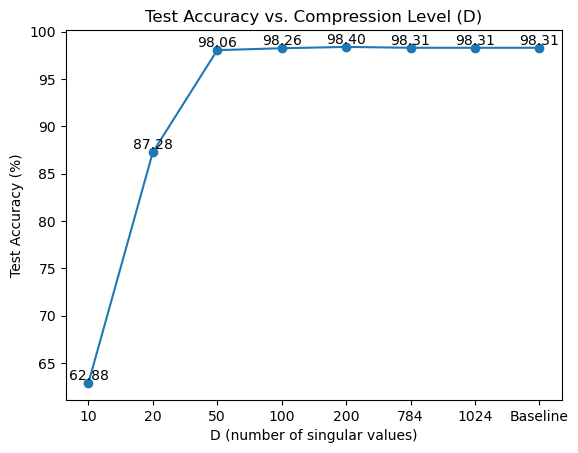

In [9]:
accuracies_all = accuracies.copy()
accuracies_all.extend([performance_baseline[1]])
accuracies_all = [acc*100 for acc in accuracies_all]
plt.plot(['10', '20', '50', '100', '200', '784', '1024', 'Baseline'], 
         accuracies_all, 
         marker='o')
plt.xlabel("D (number of singular values)")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs. Compression Level (D)")
for i, accuracy in enumerate(accuracies_all):
    plt.text(i, accuracy, f"{accuracy:.2f}", ha='center', va='bottom')
plt.show()

In [10]:
for d, param in zip(D, param_counts):
    print(f'For {d}, number of params is {param}')

For 10, number of params is 115420
For 20, number of params is 215470
For 50, number of params is 515620
For 100, number of params is 1015870
For 200, number of params is 2016370
For 784, number of params is 7859290
For 1024, number of params is 10260490


In [11]:
print(f'For Baseline, number of params is {model_baseline.count_params()}')

For Baseline, number of params is 5012490


# Problem 2

In [50]:
import tensorflow as tf

class FactorizedCompressedLayer(tf.keras.layers.Layer):
    def __init__(self, output_units, init_u, init_v, d=20):
        super().__init__()
        self.output_units = output_units
        self.init_u = init_u
        self.init_v = init_v
        self.d = d

    def build(self, input_shape):
        self.u = self.add_weight(
            shape=(input_shape[-1], self.d),
            initializer=tf.keras.initializers.Constant(self.init_u),
            trainable=True,
            name="u"
        )

        self.v = self.add_weight(
            shape=(self.d, self.output_units),
            initializer=tf.keras.initializers.Constant(self.init_v),
            trainable=True,
            name="v"
        )

        self.bias = self.add_weight(
            shape=(self.output_units,),
            initializer='zeros',
            trainable=True,
            name="bias"
        )
        
    def call(self, inputs):
        compressed_output = tf.matmul(inputs, tf.matmul(self.u, self.v))
        return compressed_output + self.bias

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28))
])

d = 20
for layer in model_baseline.layers[1:-1]:
    u, s, v = tf.linalg.svd(layer.weights[0])
    model2.add(FactorizedCompressedLayer(1024, 
                                         s[:,:d], 
                                         tf.matmul(tf.linalg.diag(u[:d]), tf.transpose(v[:, :d])), 
                                         d=d))
    model2.add(tf.keras.layers.Activation('relu'))

model2.add(tf.keras.layers.Dense(10, activation='softmax'))
model2.layers[-1].set_weights(model_baseline.layers[-1].get_weights())

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
model2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 factorized_compressed_laye  (None, 1024)              37184     
 r_15 (FactorizedCompressed                                      
 Layer)                                                          
                                                                 
 activation_10 (Activation)  (None, 1024)              0         
                                                                 
 factorized_compressed_laye  (None, 1024)              41984     
 r_16 (FactorizedCompressed                                      
 Layer)                                                          
                                                                 
 activation_11 (Activation)  (None, 1024)            

In [51]:
model2_history = model2.fit(x_train, 
                            y_train, 
                            epochs=50, 
                            batch_size=512, 
                            validation_split = 0.2)

Epoch 1/50
94/94 [==============================] - 5s 50ms/step - loss: 0.3409 - accuracy: 0.9130 - val_loss: 0.2396 - val_accuracy: 0.9384
Epoch 2/50
94/94 [==============================] - 5s 56ms/step - loss: 0.2172 - accuracy: 0.9467 - val_loss: 0.1754 - val_accuracy: 0.9573
Epoch 3/50
94/94 [==============================] - 5s 54ms/step - loss: 0.1714 - accuracy: 0.9591 - val_loss: 0.1511 - val_accuracy: 0.9630
Epoch 4/50
94/94 [==============================] - 5s 55ms/step - loss: 0.1515 - accuracy: 0.9636 - val_loss: 0.1382 - val_accuracy: 0.9664
Epoch 5/50
94/94 [==============================] - 5s 57ms/step - loss: 0.1388 - accuracy: 0.9663 - val_loss: 0.1295 - val_accuracy: 0.9693
Epoch 6/50
94/94 [==============================] - 5s 56ms/step - loss: 0.1291 - accuracy: 0.9682 - val_loss: 0.1227 - val_accuracy: 0.9711
Epoch 7/50
94/94 [==============================] - 5s 55ms/step - loss: 0.1215 - accuracy: 0.9697 - val_loss: 0.1173 - val_accuracy: 0.9727
Epoch 8/50
94

In [52]:
model2_performance = model2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0983 - accuracy: 0.9767


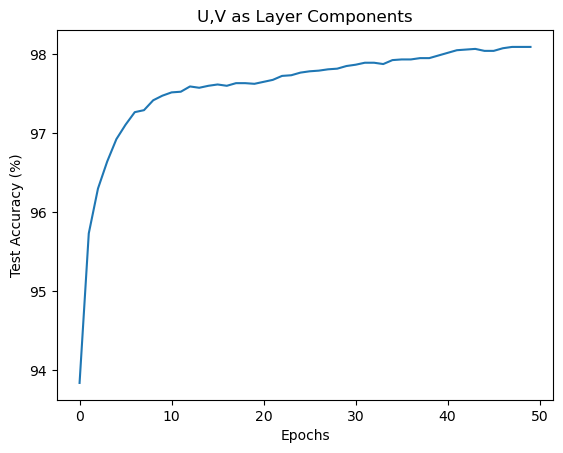

In [53]:
plt.plot([acc*100 for acc in model2_history.history['val_accuracy']])
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.title("U,V as Layer Components")
plt.show()

# Problem 3

In [54]:
class SVDForwardPropagationLayer(tf.keras.layers.Layer):
    def __init__(self, units, d=20):
        super().__init__()
        self.units = units
        self.d = d

    def build(self, input_shape):
        self.unit = self.add_weight(
            shape=(input_shape[1], self.units),
            initializer='glorot_normal',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        
    def call(self, inputs):
        u, s, v = tf.linalg.svd(self.unit)
        compressed_unit = tf.matmul(
            s[:, :self.d],
            tf.matmul(
                tf.linalg.diag(u[:self.d]),
                tf.transpose(v[:, :self.d])))
        return tf.matmul(inputs, compressed_unit) + self.bias

In [55]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28))
])

for _ in range(5):
    model3.add(SVDForwardPropagationLayer(1024))
    model3.add(tf.keras.layers.Activation('relu'))

model3.add(tf.keras.layers.Dense(10, activation='softmax'))

for i, layer_index in enumerate(range(1, 10, 2)):
    model3.layers[layer_index].set_weights(model_baseline.layers[i+1].get_weights())

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 svd_forward_propagation_la  (None, 1024)              803840    
 yer (SVDForwardPropagation                                      
 Layer)                                                          
                                                                 
 activation_15 (Activation)  (None, 1024)              0         
                                                                 
 svd_forward_propagation_la  (None, 1024)              1049600   
 yer_1 (SVDForwardPropagati                                      
 onLayer)                                                        
                                                                 
 activation_16 (Activation)  (None, 1024)            

In [56]:
model3_history = model3.fit(x_train, 
                            y_train, 
                            epochs=5, 
                            batch_size=512, 
                            validation_split=0.2)

Epoch 1/5
94/94 [==============================] - 62s 656ms/step - loss: 0.1965 - accuracy: 0.9496 - val_loss: 0.0719 - val_accuracy: 0.9799
Epoch 2/5
94/94 [==============================] - 66s 703ms/step - loss: 0.0628 - accuracy: 0.9825 - val_loss: 0.0794 - val_accuracy: 0.9798
Epoch 3/5
94/94 [==============================] - 69s 731ms/step - loss: 0.0487 - accuracy: 0.9861 - val_loss: 0.0727 - val_accuracy: 0.9801
Epoch 4/5
94/94 [==============================] - 68s 720ms/step - loss: 0.0391 - accuracy: 0.9882 - val_loss: 0.0667 - val_accuracy: 0.9820
Epoch 5/5
94/94 [==============================] - 67s 719ms/step - loss: 0.0370 - accuracy: 0.9884 - val_loss: 0.0737 - val_accuracy: 0.9812


In [57]:
model3_performance = model3.evaluate(x_test, y_test)

313/313 [==============================] - 114s 363ms/step - loss: 0.0927 - accuracy: 0.9773


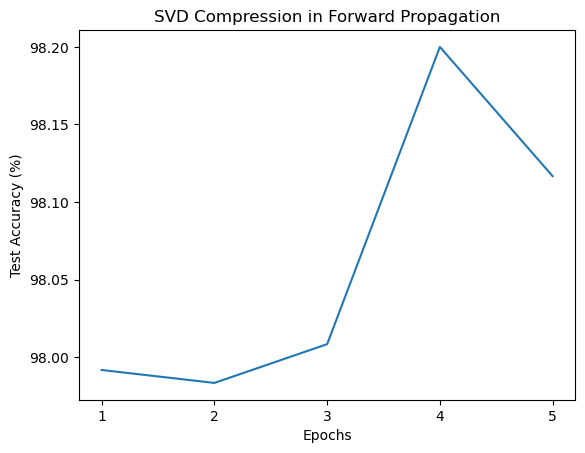

In [58]:
plt.plot(['1','2','3','4','5'],[acc*100 for acc in model3_history.history['val_accuracy']])
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.title("SVD Compression in Forward Propagation")
plt.show()

# Problem 4

In [2]:
import pickle

with open('/kaggle/input/hwork3/trs.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('/kaggle/input/hwork3/tes.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [3]:
def create_siamese_data(samples, num_speakers, utterances_per_speaker):
    num_pos_pairs = math.comb(utterances_per_speaker, 2)
    # generate positive pairs
    positives = []
    for speaker in range(num_speakers):
        speaker_samples = samples[speaker * utterances_per_speaker:(speaker + 1) * utterances_per_speaker]
        pos_pairs = []
        while len(pos_pairs) < num_pos_pairs:
            pair = np.random.choice(range(utterances_per_speaker), size=2, replace=False)
            if pair[0] != pair[1] and (pair[1], pair[0]) not in pos_pairs:
                pos_pairs.append(tuple(pair))
        for i, j in pos_pairs:
            positives.append((speaker_samples[i], speaker_samples[j]))
    # generate negative pairs
    negatives = []
    for speaker in range(num_speakers):
        speaker_samples = samples[speaker * utterances_per_speaker:(speaker + 1) * utterances_per_speaker]
        other_speakers = [s for s in range(num_speakers) if s != speaker]
        neg_pairs = []
        for _ in range(num_pos_pairs):
            # Select a random utterance index for the main speaker
            main_index = np.random.choice(range(utterances_per_speaker))
            main_sample = speaker_samples[main_index]
            # Select a random different speaker and an utterance index from that speaker
            other_speaker = np.random.choice(other_speakers)
            other_samples = samples[other_speaker * utterances_per_speaker:(other_speaker + 1) * utterances_per_speaker]
            other_index = np.random.choice(range(utterances_per_speaker))
            other_sample = other_samples[other_index]
            neg_pairs.append((main_sample, other_sample))
        negatives.extend(neg_pairs)
    return np.array(positives), np.array(negatives)
    
def compute_stft_pairs(pairs):
    stft_pairs = []
    for (utterance1, utterance2) in pairs:
        stft1 = np.abs(librosa.stft(utterance1, n_fft=1024))
        stft2 = np.abs(librosa.stft(utterance2, n_fft=1024))
        stft_pairs.append((stft1, stft2))
    return np.array(stft_pairs)

In [4]:
train_positive, train_negative = create_siamese_data(train_data, 50, 10)
test_positive, test_negative = create_siamese_data(test_data, 20, 10)

In [5]:
train_positive_stft = compute_stft_pairs(train_positive)
train_negative_stft = compute_stft_pairs(train_negative)
test_positive_stft = compute_stft_pairs(test_positive)
test_negative_stft = compute_stft_pairs(test_negative)

In [6]:
x_train = np.concatenate((train_positive_stft, train_negative_stft), axis=0)
y_train = np.array([1] * len(train_positive_stft) + [0] * len(train_negative_stft))
x_test = np.concatenate((test_positive_stft, test_negative_stft), axis=0)
y_test = np.array([1] * len(test_positive_stft) + [0] * len(test_negative_stft))

x_train = np.transpose(x_train, (0, 1, 3, 2))  
x_test = np.transpose(x_test, (0, 1, 3, 2))

In [18]:
input_layer = tf.keras.layers.Input(shape=(2,None,513))

crop_layer1 = tf.keras.layers.Cropping2D(cropping=((0,1),(0,0)))(input_layer)
reshape_crop_layer1 = tf.keras.layers.Reshape((-1, 513))(crop_layer1)
lstm_layer11 = tf.keras.layers.GRU(128,return_sequences=True)(reshape_crop_layer1)
lstm_layer12 = tf.keras.layers.LSTM(128,return_sequences=True)(lstm_layer11)
crop_layer2 = tf.keras.layers.Cropping2D(cropping=((1,0),(0,0)))(input_layer)
reshape_crop_layer2 = tf.keras.layers.Reshape((-1, 513))(crop_layer2)
lstm_layer21 = tf.keras.layers.GRU(128,return_sequences=True)(reshape_crop_layer2)
lstm_layer22 = tf.keras.layers.LSTM(128,return_sequences=True)(lstm_layer21)

dot_product = tf.keras.layers.Dot(axes=1, normalize=True)([lstm_layer12, lstm_layer22])
flattened_dot_product = tf.keras.layers.Flatten()(dot_product)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(flattened_dot_product)

model4 = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2, None,   │          0 │ -                 │
│ (InputLayer)        │ 513)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d_6        │ (None, 1, None,   │          0 │ input_layer_3[0]… │
│ (Cropping2D)        │ 513)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d_7        │ (None, 1, None,   │          0 │ input_layer_3[0]… │
│ (Cropping2D)        │ 513)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, None, 513) │          0 │ cropping2d_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, None, 513) │          0 │ cropping2d_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, None, 128) │    246,912 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, None, 128) │    246,912 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, None, 128) │    131,584 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, None, 128) │    131,584 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 128, 128)  │          0 │ lstm_12[0][0],    │
│                     │                   │            │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 16384)     │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     16,385 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 773,377 (2.95 MB)

 Trainable params: 773,377 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model4_history = model4.fit(x_train, 
                            y_train, 
                            epochs=20, 
                            batch_size=512, 
                            validation_split = 0.2
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.5131 - loss: 1.0368 - val_accuracy: 0.1444 - val_loss: 1.0479
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6781 - loss: 0.5974 - val_accuracy: 0.0156 - val_loss: 1.7907
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6764 - loss: 0.5962 - val_accuracy: 0.1033 - val_loss: 1.4441
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7380 - loss: 0.5155 - val_accuracy: 0.4267 - val_loss: 1.0020
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8220 - loss: 0.4100 - val_accuracy: 0.3411 - val_loss: 1.4277
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8381 - loss: 0.3740 - val_accuracy: 0.3633 - val_loss: 1.3877
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8520 - loss: 0.3418 - val_accuracy: 0.6700 - val_loss: 0.6642
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8705 - loss: 0.3180 - val_accuracy: 0.4178 - val_loss:

#### Test Accuracy

In [20]:
performance_model4 = model4.evaluate(x_test, y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7924 - loss: 0.4854


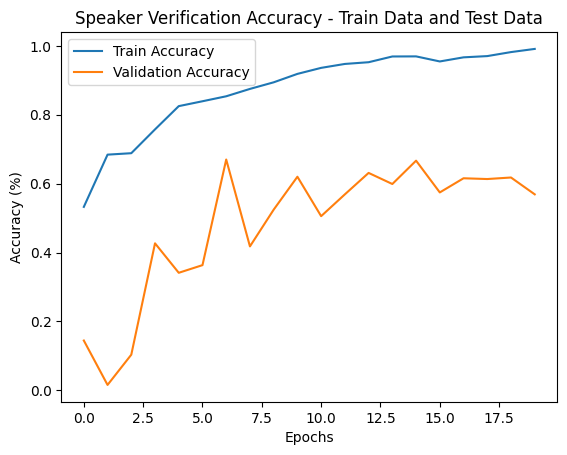

In [21]:
plt.plot(model4_history.history['accuracy'], label = 'Train Accuracy')
plt.plot(model4_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Speaker Verification Accuracy - Train Data and Test Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Problem 5

In [18]:
def load_audio_files(base_path, file_prefix, num_files):
    spectrograms = []
    for i in range(num_files):
        audio, _ = librosa.load(f'{base_path}/{file_prefix}{str(i).zfill(4)}.wav', sr=None)
        spectrogram = librosa.stft(audio, n_fft=1024, hop_length=256)
        spectrograms.append(spectrogram)
    return spectrograms

def pad_spectrograms(spectrograms, max_length):
    padded_specs = []
    for spec in spectrograms:
        if spec.shape[1] < max_length:
            spec = np.pad(spec, ((0,0), (0, max_length - spec.shape[1])))
        padded_specs.append(spec)
    return np.array(padded_specs)

In [19]:
train_size = 1200

train_speech = load_audio_files('/kaggle/input/homework3/timit-homework/tr', 'trs', train_size)
train_noise = load_audio_files('/kaggle/input/homework3/timit-homework/tr', 'trn', train_size)
train_mixed = load_audio_files('/kaggle/input/homework3/timit-homework/tr', 'trx', train_size)
max_length_train = max([max([train_speech[i].shape[1] for i in range(train_size)]), max([train_noise[i].shape[1] for i in range(train_size)]), max([train_mixed[i].shape[1] for i in range(train_size)])])

train_speech = pad_spectrograms(train_speech, max_length_train)
train_noise = pad_spectrograms(train_noise, max_length_train)
train_mixed = pad_spectrograms(train_mixed, max_length_train)

val_speech = load_audio_files('/kaggle/input/homework3/timit-homework/v', 'vs', train_size)
val_noise = load_audio_files('/kaggle/input/homework3/timit-homework/v', 'vn', train_size)
val_mixed = load_audio_files('/kaggle/input/homework3/timit-homework/v', 'vx', train_size)
max_length_val = max([max([val_speech[i].shape[1] for i in range(train_size)]), max([val_noise[i].shape[1] for i in range(train_size)]), max([val_mixed[i].shape[1] for i in range(train_size)])])

val_speech = pad_spectrograms(val_speech, max_length_val)
val_noise = pad_spectrograms(val_noise, max_length_val)
val_mixed = pad_spectrograms(val_mixed, max_length_val)

test_size = 400
test_mixed = load_audio_files('/kaggle/input/homework3/timit-homework/te', 'tex', test_size)
max_length_test = max([test_mixed[i].shape[1] for i in range(test_size)])

test_mixed = pad_spectrograms(test_mixed, max_length_test)

print('Train Mixed:', train_mixed.shape)
print('Val Mixed:', val_mixed.shape)
print('Test Mixed:', test_mixed.shape)

Train Mixed: (1200, 513, 355)
Val Mixed: (1200, 513, 355)
Test Mixed: (400, 513, 389)


In [20]:
def prepare_data(mixed_specs, speech_specs, noise_specs):
    mixed_abs = np.abs(mixed_specs)
    speech_abs = np.abs(speech_specs)
    noise_abs = np.abs(noise_specs)
    X = np.transpose(mixed_abs, (0,2,1))
    Y = np.transpose((speech_abs > noise_abs).astype(int), (0,2,1))
    return X, Y

x_train, y_train = prepare_data(train_mixed, train_speech, train_noise)
x_val, y_val = prepare_data(val_mixed, val_speech, val_noise)
x_test = np.transpose(np.abs(test_mixed), (0,2,1))

print('X-Train:', x_train.shape, ', Y-Train:', y_train.shape)
print('X-Val:', x_val.shape, ', Y-Val:', y_val.shape)
print('X-Test:', x_test.shape)

X-Train: (1200, 355, 513) , Y-Train: (1200, 355, 513)
X-Val: (1200, 355, 513) , Y-Val: (1200, 355, 513)
X-Test: (400, 389, 513)


In [21]:
model5 = keras.models.Sequential([
        keras.layers.Input(shape=(None, 513)),
        keras.layers.LSTM(513, return_sequences=True, dropout=0.2),
        keras.layers.LSTM(513, return_sequences=True, dropout=0.2),
        keras.layers.Dense(513, activation='sigmoid')
    ])

model5.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, None, 513)      │     2,107,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, None, 513)      │     2,107,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 513)      │       263,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,478,490 (17.08 MB)

 Trainable params: 4,478,490 (17.08 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model5_history = model5.fit(x_train, 
                            y_train,
                            epochs=200,
                            batch_size=64,
                            validation_data=(x_val, y_val))

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 5.0709e-04 - loss: 0.6197 - val_accuracy: 1.3850e-04 - val_loss: 0.4357
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 3.4924e-04 - loss: 0.4132 - val_accuracy: 9.6948e-04 - val_loss: 0.3943
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 9.4653e-04 - loss: 0.3850 - val_accuracy: 7.6056e-04 - val_loss: 0.3666
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.0020 - loss: 0.3597 - val_accuracy: 0.0104 - val_loss: 0.3513
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.0286 - loss: 0.3384 - val_accuracy: 0.0459 - val_loss: 0.3109
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0335 - loss: 0.3194 - val_accuracy: 0.0787 - val_loss: 0.2977
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1487 - loss: 0.2996 - val_accuracy: 0.3300 - val_loss: 0.3027
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3282 - loss: 0.2942 - 

In [23]:
def calculate_snr(orig, pred):
    return 10 * tf.experimental.numpy.log10(tf.reduce_sum(tf.square(orig)) / tf.reduce_sum(tf.square(orig - pred)))

In [24]:
train_masks = model5.predict(x_train)
train_masks = np.transpose(train_masks, (0,2,1))
train_reconstructed = np.multiply(train_masks, train_mixed)
train_snr = np.array([calculate_snr(np.abs(train_speech)[i], np.abs(train_reconstructed[i])) for i in range(train_size)])

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step


In [25]:
val_masks = model5.predict(x_val)
val_masks = np.transpose(val_masks, (0,2,1))
val_reconstructed = np.multiply(val_masks, val_mixed)
val_snr = np.array([calculate_snr(np.abs(val_speech)[i], np.abs(val_reconstructed[i])) for i in range(train_size)])

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step


In [26]:
print("Average SNR for Training Set:", np.mean(train_snr))
print("Average SNR for Validation Set:", np.mean(val_snr))

Average SNR for Training Set: 13.591594
Average SNR for Validation Set: 12.6114645


In [27]:
model5.save('rit-p5.h5')

In [30]:
os.makedirs('ritshriv_p5_output', exist_ok=True)

In [32]:
for i in range(400):
    x, sr = librosa.load(f'/kaggle/input/homework3/timit-homework/te/tex{str(i).zfill(4)}.wav', sr=None)
    spec = librosa.stft(x, n_fft=1024, hop_length=256)
    spec_abs = np.abs(spec)
    ip = np.expand_dims(spec_abs, 0).transpose((0, 2, 1))
    spec_mask = model5.predict(ip)
    recons = np.multiply(spec_mask.transpose((0, 2, 1)), spec)
    op = librosa.istft(recons[0], n_fft=1024, hop_length=256)
    sf.write(f"ritshriv_p5_output/output_{i}.wav", op, sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
print('done')

done


In [36]:
!cd /kaggle/working

In [39]:
!zip -r ritshriv_p5_output.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/ritshriv_p5_output/ (stored 0%)
  adding: kaggle/working/ritshriv_p5_output/output_59.wav (deflated 36%)
  adding: kaggle/working/ritshriv_p5_output/output_122.wav (deflated 45%)
  adding: kaggle/working/ritshriv_p5_output/output_354.wav (deflated 33%)
  adding: kaggle/working/ritshriv_p5_output/output_216.wav (deflated 37%)
  adding: kaggle/working/ritshriv_p5_output/output_313.wav (deflated 37%)
  adding: kaggle/working/ritshriv_p5_output/output_370.wav (deflated 36%)
  adding: kaggle/working/ritshriv_p5_output/output_252.wav (deflated 31%)
  adding: kaggle/working/ritshriv_p5_output/output_362.wav (deflated 36%)
  adding: kaggle/working/ritshriv_p5_output/output_4.wav (deflated 38%)
  adding: kaggle/working/ritshriv_p5_output/output_190.wav (deflated 43%)
  adding: kaggle/working/ritshriv_p5_output/output_328.wav (deflated 35%)
  adding: kaggle/working/ritshriv_p5_output/output_236.wav (deflated 45%)
  adding: kaggle/wor